<ipython-input-1-5925edd34633>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace({'label': emotion_mapping}).infer_objects(copy=False) # type conversion


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4048 - loss: 1.3865 - val_accuracy: 0.5162 - val_loss: 1.1413 - learning_rate: 5.0000e-04
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5072 - loss: 1.0905 - val_accuracy: 0.4813 - val_loss: 1.1718 - learning_rate: 5.0000e-04
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5836 - loss: 0.9459 - val_accuracy: 0.5611 - val_loss: 1.0059 - learning_rate: 5.0000e-04
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5881 - loss: 0.8984 - val_accuracy: 0.6234 - val_loss: 0.9283 - learning_rate: 5.0000e-04
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6557 - loss: 0.7942 - val_accuracy: 0.6509 - val_loss: 0.8770 - learning_rate: 5.0000e-04
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7232 - loss: 0.6843 - val_accuracy: 0.6559 - val_loss: 0.8704 - learning_rate: 5.0000e-04
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - ac

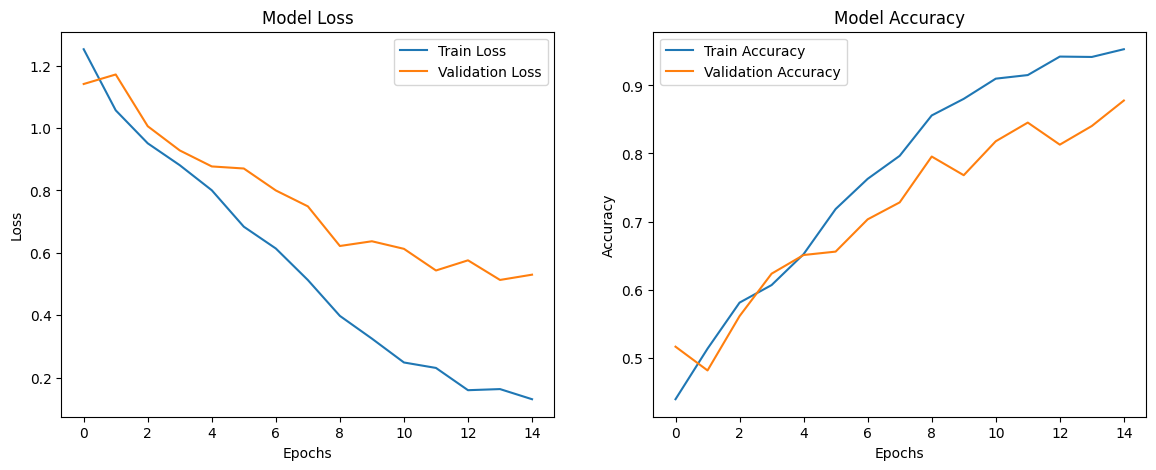

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load data
data = pd.read_csv("/kaggle/input/emotion/emotions.csv")

# Step 1: Preprocess the EEG Signals
def preprocess_data(data):
    data['label'] = data['label'].apply(lambda x: np.random.choice(['happy', 'surprise']) if x == 'POSITIVE' 
                                        else np.random.choice(['sad', 'anger', 'fear', 'disgust']) if x == 'NEGATIVE'
                                        else 'neutral')
    
    emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6} # labeling to numbers for model training
    data_encoded = data.replace({'label': emotion_mapping}).infer_objects(copy=False) # type conversion
    
    X = data_encoded.drop(columns=['label'])  # EEG signal values
    y = data_encoded['label'].values  #Emotion Labels(happy,sad...)

    scaler = StandardScaler() # performing z-score normalization for model performance and to avoid non linear values in the data
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE() #Generates synthetic samples for underrepresented classes to balance the dataset. Because eeg datasets have imbalanced emotions
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    y_onehot = to_categorical(y_resampled, num_classes=7)  # One-hot encoding for 7 emotion classes 
    #Neural networks need categorical labels in one-hot format.

    num_channels = 32 # multi-channel time-series data (e.g., 32 channels) in dataset
    num_timesteps = X_resampled.shape[1] // num_channels #represents the total number of EEG features per sample and number of channels
    if X_resampled.shape[1] % num_channels != 0:
        X_resampled = X_resampled[:, :(num_timesteps * num_channels)]

    X_reshaped = X_resampled.reshape(X_resampled.shape[0], num_timesteps, num_channels) #reshapes the EEG feature matrix into a structured time-series format suitable for deep learning models like LSTMs and Transformers.

    x_train, x_test, y_train, y_test = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(data)

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import MultiHeadAttention
import matplotlib.pyplot as plt

# -------------------- LSTM Layer --------------------
def create_lstm_layer(input_shape):
    """
    Function to create LSTM layers.
    LSTM is good for sequential data like EEG, as it captures temporal dependencies.
    """
    inputs = Input(shape=input_shape)  # Define input shape
    lstm_out = LSTM(256, return_sequences=True)(inputs)  # First LSTM layer with 256 units, returns sequences
    lstm_out = LSTM(128, return_sequences=True)(lstm_out)  # Second LSTM layer with 128 units, returns sequences
    return inputs, lstm_out  # Return input layer and LSTM output for further processing

# Define input shape based on training data
input_shape = (x_train.shape[1], x_train.shape[2])  # Shape: (time steps, channels)

# Get LSTM layer outputs
inputs, lstm_output = create_lstm_layer(input_shape)

# -------------------- Transformer Layer --------------------
class TransformerBlock(tf.keras.layers.Layer):
    """
    Custom Transformer block to enhance feature extraction.
    Uses multi-head self-attention and feedforward layers.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Multi-head attention mechanism
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),  # Feedforward network with ReLU activation
            Dense(embed_dim),  # Output dimension should match the input embedding dimension
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # Normalize layer to stabilize training
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # Another normalization after FFN
        self.dropout1 = Dropout(rate)  # Dropout after attention to prevent overfitting
        self.dropout2 = Dropout(rate)  # Dropout after FFN to prevent overfitting

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # Self-attention mechanism
        attn_output = self.dropout1(attn_output, training=training)  # Dropout during training
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection & normalization

        ffn_output = self.ffn(out1)  # Passing through FFN
        ffn_output = self.dropout2(ffn_output, training=training)  # Dropout after FFN
        return self.layernorm2(out1 + ffn_output)  # Another residual connection & normalization
# -------------------- LSTM + Transformer Model --------------------
def build_lstm_transformer_model(input_shape):
    """
    Function to build a hybrid LSTM + Transformer model.
    LSTM captures temporal dependencies, and Transformer enhances attention-based feature extraction.
    """
    inputs, lstm_output = create_lstm_layer(input_shape)  # Get LSTM outputs

    # Create a Transformer block with specified parameters
    transformer_block = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)
    transformer_output = transformer_block(lstm_output, training=True)  # Apply Transformer on LSTM output

    flatten = GlobalAveragePooling1D()(transformer_output)  # Convert sequence output to a single vector
    output = Dense(7, activation='softmax')(flatten)  # Final dense layer for classification (7 emotion classes)

    model = Model(inputs=inputs, outputs=output)  # Define the complete model

    # Compile model with AdamW optimizer, categorical crossentropy loss (since we have multiple classes),
    # and accuracy as the metric to track performance.
    model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Build model using the defined function
model = build_lstm_transformer_model(input_shape)

# -------------------- Training --------------------
# Define early stopping and learning rate scheduler to improve model performance
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate scheduler to improve model performance
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Stops training if no improvement for 10 epochs
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduces learning rate if validation loss stagnates


# Train the model
history = model.fit(
    x_train, y_train,  # Training data
    epochs=15,  # Train for 15 epochs
    validation_split=0.1,  # Use 10% of training data for validation
    batch_size=32,  # Number of samples per batch
    callbacks=[early_stop, lr_scheduler]  # Apply early stopping & learning rate scheduling
)


# Create a feature extraction model that outputs the activations from the "global_average_pooling1d" layer of the trained model.
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer("global_average_pooling1d").output)

# Use the feature extractor to generate feature vectors for the training and test data.
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Convert one-hot encoded labels back to categorical class labels (0 to 6 corresponding to emotions).
train_labels = np.argmax(y_train, axis=1)  # Converts one-hot encoded labels into their respective class indices.
test_labels = np.argmax(y_test, axis=1)  # Converts one-hot encoded labels into their respective class indices.

# Save the extracted features and labels to CSV files.
train_df = pd.DataFrame(train_features)
train_df['emotion'] = train_labels
train_df.to_csv("/kaggle/working/train_features.csv", index=False)

test_df = pd.DataFrame(test_features)
test_df['emotion'] = test_labels
test_df.to_csv("/kaggle/working/test_features.csv", index=False)

# Print confirmation message indicating that the extracted features and labels have been successfully saved.
print("Train and test features saved to CSV files.")

# -------------------- Evaluation --------------------
# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# -------------------- Plot Training History --------------------
# Create two subplots: one for loss and one for accuracy
plt.figure(figsize=(14, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss curve
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss curve
plt.title('Model Loss')  # Title of plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy curve
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy curve
plt.title('Model Accuracy')  # Title of plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend

# Show the plots
plt.show()


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
# Load data
data = pd.read_csv("/kaggle/input/emotion/emotions.csv")

# Step 1: Preprocess the EEG Signals
def preprocess_data(data):
    data['label'] = data['label'].apply(lambda x: np.random.choice(['happy', 'surprise']) if x == 'POSITIVE' 
                                        else np.random.choice(['sad', 'anger', 'fear', 'disgust']) if x == 'NEGATIVE'
                                        else 'neutral')
    
    emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'anger': 3, 'surprise': 4, 'fear': 5, 'disgust': 6} # labeling to numbers for model training
    data_encoded = data.replace({'label': emotion_mapping}).infer_objects(copy=False) # type conversion

    X = data_encoded.drop(columns=['label'])  # EEG signal values
    y = data_encoded['label'].values  #Emotion Labels(happy,sad...)

    scaler = StandardScaler() # performing z-score normalization for model performance and to avoid non linear values in the data
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE() #Generates synthetic samples for underrepresented classes to balance the dataset. Because eeg datasets have imbalanced emotions
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    y_onehot = to_categorical(y_resampled, num_classes=7)  # One-hot encoding for 7 emotion classes 
    #Neural networks need categorical labels in one-hot format.

    num_channels = 32 # multi-channel time-series data (e.g., 32 channels) in dataset
    num_timesteps = X_resampled.shape[1] // num_channels #represents the total number of EEG features per sample and number of channels
    if X_resampled.shape[1] % num_channels != 0:
        X_resampled = X_resampled[:, :(num_timesteps * num_channels)]

    X_reshaped = X_resampled.reshape(X_resampled.shape[0], num_timesteps, num_channels) #reshapes the EEG feature matrix into a structured time-series format suitable for deep learning models like LSTMs and Transformers.

    x_train, x_test, y_train, y_test = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(data)

<ipython-input-3-84b29ddecb5b>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace({'label': emotion_mapping}).infer_objects(copy=False) # type conversion


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import MultiHeadAttention
import matplotlib.pyplot as plt

In [5]:
# -------------------- LSTM Layer --------------------
def create_lstm_layer(input_shape):
    """
    Function to create LSTM layers.
    LSTM is good for sequential data like EEG, as it captures temporal dependencies.
    """
    inputs = Input(shape=input_shape)  # Define input shape
    lstm_out = LSTM(256, return_sequences=True)(inputs)  # First LSTM layer with 256 units, returns sequences
    lstm_out = LSTM(128, return_sequences=True)(lstm_out)  # Second LSTM layer with 128 units, returns sequences
    return inputs, lstm_out  # Return input layer and LSTM output for further processing

# Define input shape based on training data
input_shape = (x_train.shape[1], x_train.shape[2])  # Shape: (time steps, channels)

# Get LSTM layer outputs
inputs, lstm_output = create_lstm_layer(input_shape)

In [6]:
# -------------------- Transformer Layer --------------------
class TransformerBlock(tf.keras.layers.Layer):
    """
    Custom Transformer block to enhance feature extraction.
    Uses multi-head self-attention and feedforward layers.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Multi-head attention mechanism
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),  # Feedforward network with ReLU activation
            Dense(embed_dim),  # Output dimension should match the input embedding dimension
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # Normalize layer to stabilize training
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # Another normalization after FFN
        self.dropout1 = Dropout(rate)  # Dropout after attention to prevent overfitting
        self.dropout2 = Dropout(rate)  # Dropout after FFN to prevent overfitting

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # Self-attention mechanism
        attn_output = self.dropout1(attn_output, training=training)  # Dropout during training
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection & normalization

        ffn_output = self.ffn(out1)  # Passing through FFN
        ffn_output = self.dropout2(ffn_output, training=training)  # Dropout after FFN
        return self.layernorm2(out1 + ffn_output)  # Another residual connection & normalization

In [7]:
# -------------------- LSTM + Transformer Model --------------------
def build_lstm_transformer_model(input_shape):
    """
    Function to build a hybrid LSTM + Transformer model.
    LSTM captures temporal dependencies, and Transformer enhances attention-based feature extraction.
    """
    inputs, lstm_output = create_lstm_layer(input_shape)  # Get LSTM outputs

    # Create a Transformer block with specified parameters
    transformer_block = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)
    transformer_output = transformer_block(lstm_output, training=True)  # Apply Transformer on LSTM output

    flatten = GlobalAveragePooling1D()(transformer_output)  # Convert sequence output to a single vector
    output = Dense(7, activation='softmax')(flatten)  # Final dense layer for classification (7 emotion classes)

    model = Model(inputs=inputs, outputs=output)  # Define the complete model

    # Compile model with AdamW optimizer, categorical crossentropy loss (since we have multiple classes),
    # and accuracy as the metric to track performance.
    model.compile(optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Build model using the defined function
model = build_lstm_transformer_model(input_shape)

In [8]:
# -------------------- Training --------------------
# Define early stopping and learning rate scheduler to improve model performance
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate scheduler to improve model performance
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Stops training if no improvement for 10 epochs
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduces learning rate if validation loss stagnates


# Train the model
history = model.fit(
    x_train, y_train,  # Training data
    epochs=15,  # Train for 15 epochs
    validation_split=0.1,  # Use 10% of training data for validation
    batch_size=32,  # Number of samples per batch
    callbacks=[early_stop, lr_scheduler]  # Apply early stopping & learning rate scheduling
)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3938 - loss: 1.3908 - val_accuracy: 0.4090 - val_loss: 1.2039 - learning_rate: 5.0000e-04
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5007 - loss: 1.0934 - val_accuracy: 0.5212 - val_loss: 1.0435 - learning_rate: 5.0000e-04
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5324 - loss: 1.0257 - val_accuracy: 0.5411 - val_loss: 0.9759 - learning_rate: 5.0000e-04
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5973 - loss: 0.9011 - val_accuracy: 0.5511 - val_loss: 1.0525 - learning_rate: 5.0000e-04
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6377 - loss: 0.8273 - val_accuracy: 0.6185 - val_loss: 0.8422 - learning_rate: 5.0000e-04
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7109 - loss: 0.7255 - val_accuracy: 0.6658 - val_loss: 0.7571 - learning_rate: 5.0000e-04
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc

In [9]:
# -------------------- Evaluation --------------------
# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8130 - loss: 0.4796
Test Loss: 0.4728090167045593, Test Accuracy: 0.8205384016036987


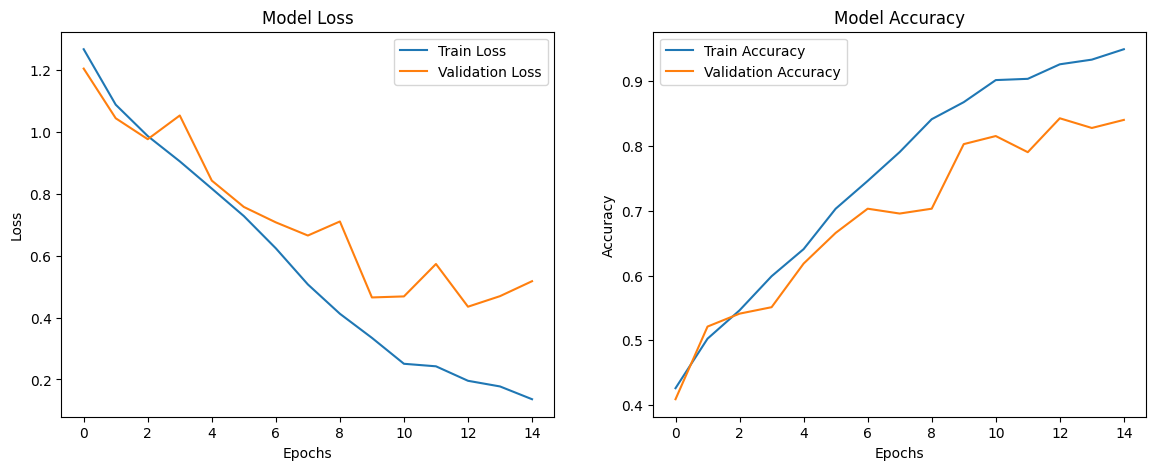

In [10]:
# -------------------- Plot Training History --------------------
# Create two subplots: one for loss and one for accuracy
plt.figure(figsize=(14, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss curve
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss curve
plt.title('Model Loss')  # Title of plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy curve
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy curve
plt.title('Model Accuracy')  # Title of plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend

# Show the plots
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

# Example input data and shape (for illustration, adjust according to your data)
input_shape = (100, 64)  # Example shape (100 timesteps, 64 features)

# Create a simple model
inputs = layers.Input(shape=input_shape)
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.GlobalAveragePooling1D()(x)  # Using the global_average_pooling1d layer

# Flatten the output before passing it to the Dense layer
x = layers.Flatten()(x)

# Define the output layer with 7 classes for classification
output = layers.Dense(7, activation='softmax')(x)

# Define the model
model = models.Model(inputs=inputs, outputs=output)

# Correct the layer name to "global_average_pooling1d_2" as per the error message
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("global_average_pooling1d_2").output)

# Example placeholders for training and test data (you should replace these with your actual data)
x_train = np.random.random((100, 100, 64))  # 100 samples, 100 timesteps, 64 features
x_test = np.random.random((20, 100, 64))   # 20 test samples
y_train = np.random.randint(0, 7, 100)     # Example labels for 7 classes
y_test = np.random.randint(0, 7, 20)

# Convert one-hot encoded labels back to categorical class labels
train_labels = np.argmax(tf.keras.utils.to_categorical(y_train, 7), axis=1)  # One-hot to class indices
test_labels = np.argmax(tf.keras.utils.to_categorical(y_test, 7), axis=1)

# Use the feature extractor to generate feature vectors for the training and test data
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Save the extracted features and labels to CSV files
train_df = pd.DataFrame(train_features)
train_df['emotion'] = train_labels
train_df.to_csv("/kaggle/working/train_features.csv", index=False)

test_df = pd.DataFrame(test_features)
test_df['emotion'] = test_labels
test_df.to_csv("/kaggle/working/test_features.csv", index=False)

# Print confirmation message indicating that the extracted features and labels have been successfully saved
print("Train and test features saved to CSV files.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Train and test features saved to CSV files.


***Facial Expression Using ViT*** 

In [12]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor, ViTModel  # Use ViTImageProcessor instead of ViTFeatureExtractor (deprecated)
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [13]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Step 1: Define the base path and image directories
base_path = '/kaggle/input/facial/images'  # Path to the dataset containing facial images
train_path = os.path.join(base_path, 'train')  # Path to training images
validation_path = os.path.join(base_path, 'validation')  # Path to validation images

In [15]:
# Step 2: Load and preprocess the images
# Define the preprocessing pipeline for Vision Transformer (ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels (required input size for ViT)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1] range
])

# Load the dataset using ImageFolder (which automatically assigns labels based on folder names)
train_dataset = ImageFolder(root=train_path, transform=transform)  # Load training dataset
validation_dataset = ImageFolder(root=validation_path, transform=transform)  # Load validation dataset

# Create DataLoaders for efficient data loading and batching
# num_workers > 0 enables parallel data loading, pin_memory=True speeds up data transfer to GPU
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [16]:
# Step 3: Load a pre-trained Vision Transformer (ViT) model

from transformers import ViTModel, ViTConfig, ViTImageProcessor

# Load ViT configuration and disable the pooler layer
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.has_pooler = False  # Prevents the pooler from being initialized

# Load the ViT image processor (formerly feature extractor)
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Load the pre-trained ViT model with the modified config
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224", config=config)

# Move the ViT model to GPU if available
vit_model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [17]:
# Step 4: Define a function to extract feature vectors from images using ViT
def extract_features(dataloader, model, device):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch normalization updates)
    features, labels = [], []  # Initialize empty lists to store features and labels

    with torch.no_grad():  # Disable gradient computation for faster inference
        for images, batch_labels in dataloader:
            images = images.to(device)  # Move image batch to GPU
            batch_labels = batch_labels.to(device)  # Move label batch to GPU

            # Extract features from ViT
            outputs = model(images)  # Forward pass through ViT
            # Use the [CLS] token's output as the feature vector (ViT encodes whole image as a token sequence)
            cls_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract features and move to CPU
            features.extend(cls_features)  # Store extracted features
            labels.extend(batch_labels.cpu().numpy())  # Store corresponding labels

    return features, labels  # Return extracted features and labels

# Define device (make sure to check if GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the device
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_model = vit_model.to(device)

# Define DataLoader (assuming you already have train_dataset defined)
train_dataset = ImageFolder(root=train_path, transform=transform) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Extract features
train_features, train_labels = extract_features(train_loader, vit_model, device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Step 5: Reduce dimensionality of extracted facial features to 128 (to match EEG feature size)
def reduce_dimensions(features, target_dim=128):
    pca = PCA(n_components=target_dim)  # Use Principal Component Analysis (PCA) for dimensionality reduction
    reduced_features = pca.fit_transform(features)  # Reduce feature vectors to target dimension (128)
    return reduced_features  # Return the reduced feature vectors

# Extract features for both train and validation datasets
train_features, train_labels = extract_features(train_loader, vit_model, device)
validation_features, validation_labels = extract_features(validation_loader, vit_model, device)  # FIXED LINE

# Apply PCA to reduce feature dimensions
train_features_reduced = reduce_dimensions(train_features, target_dim=128)
validation_features_reduced = reduce_dimensions(validation_features, target_dim=128)

In [19]:
# Step 6: Combine train and validation features into a single dataset
all_features = np.vstack([train_features_reduced, validation_features_reduced])  # Stack train and validation features
all_labels = np.concatenate([train_labels, validation_labels])  # Concatenate train and validation labels

# Convert extracted features into a Pandas DataFrame for easier manipulation
feature_columns = [f'feature_{i}' for i in range(all_features.shape[1])]  # Generate column names
facial_feature_vectors = pd.DataFrame(all_features, columns=feature_columns)  # Create DataFrame with features

# Add a column for numerical labels (emotion class)
facial_feature_vectors['label'] = all_labels  

In [20]:
# Step 7: Map numerical labels to emotion category names
emotion_mapping = {
    0: 'neutral', 1: 'happy', 2: 'sad', 3: 'anger', 
    4: 'surprise', 5: 'fear', 6: 'disgust'
}  # Dictionary to map numerical labels to emotion names

# Add a new column 'emotion' with mapped emotion names
facial_feature_vectors['emotion'] = facial_feature_vectors['label'].map(emotion_mapping)

In [21]:
# Step 8: Save the extracted feature vectors to a CSV file for later use
output_path = '/kaggle/working/facial_feature_vectors.csv'  # Define output file path
facial_feature_vectors.to_csv(output_path, index=False)  # Save DataFrame as CSV without index column

# Print confirmation message
print(f"Facial feature vectors extracted and saved to {output_path}.")


Facial feature vectors extracted and saved to /kaggle/working/facial_feature_vectors.csv.


**MULTI_MODAL TRAINING**

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [23]:
# Load EEG features
eeg_features = pd.read_csv("/kaggle/input/multimodal/train_features.csv")

# Load facial features
facial_features = pd.read_csv("/kaggle/input/multimodal/facial_feature_vectors (1).csv")

# Load labeled EEG data (contains theta and beta bands)
labeled_eeg_data = pd.read_csv("/kaggle/input/eeg-data/labeled_eeg_data.csv")

In [24]:
# Ensure both datasets have an 'emotion' column
if 'emotion' not in eeg_features.columns or 'emotion' not in facial_features.columns:
    raise ValueError("The 'emotion' column is missing from one of the datasets!")

# Extract labels from EEG dataset
labels = eeg_features['emotion'].values  # Get the emotion labels from the EEG dataset

# Convert categorical labels to numerical format
label_encoder = LabelEncoder()  # Initialize label encoder
labels_encoded = label_encoder.fit_transform(labels)  # Convert categorical labels (strings) to numeric values

# Convert labels to one-hot encoding (for classification tasks)
num_classes = len(np.unique(labels_encoded))  # Determine the number of unique emotion categories
labels_onehot = tf.keras.utils.to_categorical(labels_encoded, num_classes=num_classes)  # Convert to one-hot encoded format

# Drop 'emotion' column from both datasets, as we only need the feature vectors
eeg_features = eeg_features.drop(columns=['emotion'])
facial_features = facial_features.drop(columns=['emotion'])

# Align facial features with EEG data (Truncate or pad if needed)
facial_features = facial_features.iloc[:len(eeg_features)].reset_index(drop=True)  # Ensure both datasets have the same length

# Ensure data is properly aligned
assert len(eeg_features) == len(facial_features), "EEG and Facial features must have the same number of samples!"

In [25]:
# Extract cognitive load feature (Theta/Beta ratio from labeled EEG data)
def calculate_cognitive_load(eeg_data):
    # Check if theta and beta band columns exist in the dataset
    if not any(eeg_data.columns.str.contains('theta')) or not any(eeg_data.columns.str.contains('beta')):
        raise ValueError("Theta or Beta band columns missing in labeled EEG data!")
    
    theta_band = eeg_data.filter(regex='theta', axis=1).mean(axis=1)  # Compute mean theta power
    beta_band = eeg_data.filter(regex='beta', axis=1).mean(axis=1)  # Compute mean beta power
    
    return theta_band / beta_band  # Compute Cognitive Load Index (CLI) as theta/beta ratio

cognitive_load_index = calculate_cognitive_load(labeled_eeg_data)  # Compute CLI for each sample

In [26]:
# Define cognitive load categories based on CLI value
COGNITIVE_LOAD_THRESHOLD = 3.0  # Threshold value determined through analysis

def assess_cognitive_load(cli_value):
    # Categorize cognitive load into Low, Moderate, or High based on threshold
    if cli_value < 1.5:
        return "Low Load"
    elif 1.5 <= cli_value < COGNITIVE_LOAD_THRESHOLD:
        return "Moderate Load"
    else:
        return "High Load (⚠️ Alert)"  # Alert condition for high cognitive load

# Apply the function to get cognitive load labels for all samples
cognitive_load_labels = cognitive_load_index.apply(assess_cognitive_load)

# Alert the user when high cognitive load is detected
for i, cli in enumerate(cognitive_load_index):
    if cli >= COGNITIVE_LOAD_THRESHOLD:
        print(f"⚠️ Alert: High Cognitive Load detected for sample {i} (CLI: {cli:.2f})")

⚠️ Alert: High Cognitive Load detected for sample 26 (CLI: 3.88)
⚠️ Alert: High Cognitive Load detected for sample 35 (CLI: 3.39)
⚠️ Alert: High Cognitive Load detected for sample 49 (CLI: 3.66)
⚠️ Alert: High Cognitive Load detected for sample 90 (CLI: 3.84)
⚠️ Alert: High Cognitive Load detected for sample 103 (CLI: 3.16)
⚠️ Alert: High Cognitive Load detected for sample 107 (CLI: 3.05)
⚠️ Alert: High Cognitive Load detected for sample 122 (CLI: 3.15)
⚠️ Alert: High Cognitive Load detected for sample 130 (CLI: 4.12)
⚠️ Alert: High Cognitive Load detected for sample 145 (CLI: 4.14)
⚠️ Alert: High Cognitive Load detected for sample 148 (CLI: 3.47)
⚠️ Alert: High Cognitive Load detected for sample 160 (CLI: 3.62)
⚠️ Alert: High Cognitive Load detected for sample 183 (CLI: 4.88)
⚠️ Alert: High Cognitive Load detected for sample 234 (CLI: 4.33)
⚠️ Alert: High Cognitive Load detected for sample 272 (CLI: 4.46)
⚠️ Alert: High Cognitive Load detected for sample 276 (CLI: 3.11)
⚠️ Alert: High

In [27]:
# Combine EEG and facial feature vectors into a single dataset
combined_features = np.hstack([eeg_features.values, facial_features.values])

# Normalize feature values to improve model performance
scaler = StandardScaler()  # Initialize standard scaler
combined_features_scaled = scaler.fit_transform(combined_features)  # Standardize features to zero mean, unit variance

# Split dataset into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(combined_features_scaled, labels_onehot, test_size=0.2, random_state=42)

# Build the neural network model for multimodal emotion classification
def build_multi_modal_model(input_dim):
    input_layer = Input(shape=(input_dim,))  # Define input layer with feature size
    x = Dense(256, activation='relu')(input_layer)  # Fully connected layer with 256 neurons
    x = Dropout(0.3)(x)  # Dropout for regularization (prevents overfitting)
    x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 neurons
    x = Dropout(0.3)(x)  # Dropout for regularization
    x = Dense(64, activation='relu')(x)  # Fully connected layer with 64 neurons
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for classification
    
    model = Model(inputs=input_layer, outputs=output_layer)  # Create the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile model
    
    return model

In [28]:
# Define input dimension based on the number of combined features
input_dim = combined_features_scaled.shape[1]
model = build_multi_modal_model(input_dim)  # Initialize the model

# Define callbacks for better training control
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Stop early if validation loss doesn't improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduce learning rate on plateau

In [29]:
# Train the model
history = model.fit(
    x_train, y_train,  # Training data
    epochs=50,  # Number of training epochs
    batch_size=32,  # Batch size for training
    validation_split=0.1,  # Use 10% of training data for validation
    callbacks=[early_stop, lr_scheduler]  # Apply early stopping and learning rate scheduler
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5986 - loss: 1.0856 - val_accuracy: 0.9595 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.1605 - val_accuracy: 0.9564 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9583 - loss: 0.1191 - val_accuracy: 0.9813 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.0969 - val_accuracy: 0.9720 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9633 - loss: 0.0977 - val_accuracy: 0.9751 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0634 - val_accuracy: 0.9751 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0502 - val_accuracy:

In [30]:
# Evaluate model performance on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9648 - loss: 0.1075
Test Loss: 0.11352381855249405, Test Accuracy: 0.9638404250144958


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


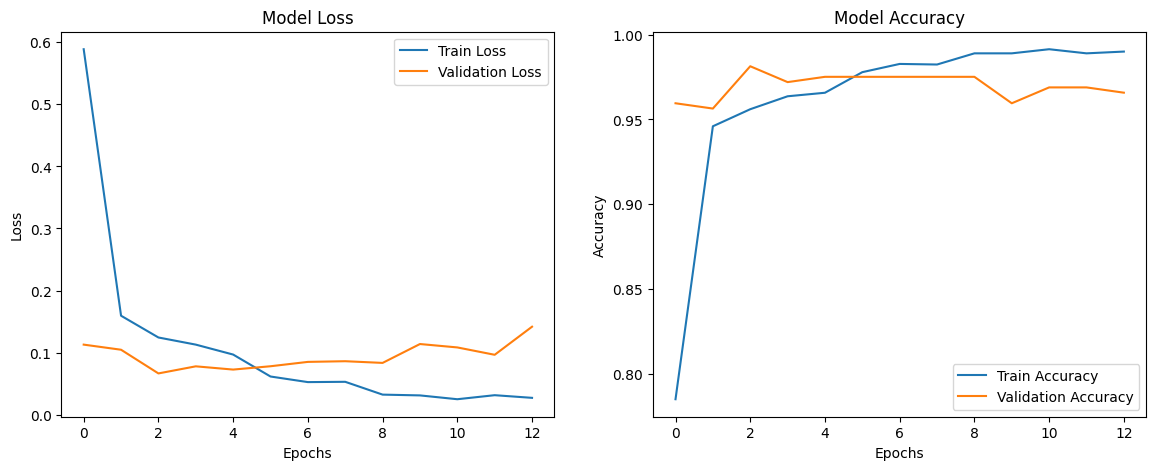

In [31]:
# Make predictions on the test set
predictions = model.predict(x_test)

# Plot Training History (Loss & Accuracy over epochs)
plt.figure(figsize=(14, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
import os 
import torch 
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader 
from transformers import ViTImageProcessor, ViTModel 
import pandas as pd  
import numpy as np  
from sklearn.decomposition import PCA 

In [33]:
# Set device (use GPU if available, otherwise fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Define dataset path (location of image dataset)
base_path = "/kaggle/input/facial/images"

In [35]:
# Function to load and process images
def process_images(image_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels (required for ViT input)
        transforms.ToTensor(),  # Convert image to tensor format
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image values
    ])
    dataset = ImageFolder(root=image_dir, transform=transform)  # Load images and apply transformations
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)  # Create DataLoader for batch processing
    return dataloader, dataset.class_to_idx  # Return DataLoader and label-to-index mapping

In [36]:
# Load pretrained ViT model
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")  # Load ViT image processor
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)  # Load ViT model and move it to the selected device (GPU/CPU)

# Function to extract features from images using the ViT model
def extract_features(dataloader, model, device):
    model.eval()  # Set model to evaluation mode
    features, labels = [], []  # Initialize empty lists to store extracted features and labels
    with torch.no_grad():  # Disable gradient computation to save memory
        for images, batch_labels in dataloader:  # Iterate over batches of images
            images = images.to(device)  # Move images to the selected device (GPU/CPU)
            outputs = model(images)  # Get model outputs
            cls_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract CLS token features from ViT output
            features.extend(cls_features)  # Store extracted features
            labels.extend(batch_labels.cpu().numpy())  # Store corresponding labels
    return np.array(features), np.array(labels)  # Convert lists to NumPy arrays and return them


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Function to compute fatigue scores from extracted features
def compute_fatigue(features):
    eye_features = features[:, :64]  # Assume the first 64 dimensions correspond to eye region features
    fatigue_scores = np.mean(np.abs(eye_features), axis=1)  # Compute mean absolute value of eye features (lower values mean closed eyes)
    return fatigue_scores  # Return fatigue scores

# Function to compute distraction scores from extracted features
def compute_distraction(features):
    head_features = features[:, 64:128]  # Assume the next 64 dimensions correspond to head movement features
    distraction_scores = np.std(head_features, axis=1)  # Compute standard deviation of head features (higher std means more movement)
    return distraction_scores  # Return distraction scores

In [38]:
# Process train and validation sets
categories = ['train', 'validation', 'train', 'validation']  # Define dataset categories

data = []  # Initialize an empty list to store processed data
for cat in categories:  # Iterate over each dataset category
    image_dir = os.path.join(base_path, cat)  # Construct path to image directory
    dataloader, label_map = process_images(image_dir)  # Load images and obtain DataLoader and label mappings
    features, labels = extract_features(dataloader, vit_model, device)  # Extract features using ViT
    fatigue_scores = compute_fatigue(features)  # Compute fatigue scores
    distraction_scores = compute_distraction(features)  # Compute distraction scores
    
    for i in range(len(labels)):  # Iterate over all extracted samples
        data.append([cat, labels[i], fatigue_scores[i], distraction_scores[i]])  # Store dataset type, label, and computed scores

In [39]:
# Save the computed fatigue and distraction scores to a CSV file
output_df = pd.DataFrame(data, columns=["Dataset", "Label", "Fatigue", "Distraction"])  # Create a Pandas DataFrame
output_df.to_csv("/kaggle/working/fatigue_distraction_scores.csv", index=False)  # Save DataFrame to CSV file
print("Fatigue and distraction scores saved.")  # Print confirmation message

Fatigue and distraction scores saved.


In [40]:
import pandas as pd
import numpy as np

In [41]:
# Load CSV Files
fatigue_distraction_file = "/kaggle/input/test-data/fatigue_distraction_scores.csv"  
cognitive_load_file = "/kaggle/input/test-data/cognitive_load_analysis.csv"  

# Read CSV files
fatigue_distraction_df = pd.read_csv(fatigue_distraction_file)
cognitive_load_df = pd.read_csv(cognitive_load_file)

In [42]:
# Convert 'Fatigue' and 'Distraction' to numeric (force errors if invalid data)
fatigue_distraction_df["Fatigue"] = pd.to_numeric(fatigue_distraction_df["Fatigue"], errors="coerce")
fatigue_distraction_df["Distraction"] = pd.to_numeric(fatigue_distraction_df["Distraction"], errors="coerce")

# Extract numerical Cognitive Load values
def extract_cli(value):
    """Extracts numeric CLI from categorical labels."""
    if isinstance(value, str) and "High" in value:
        return 3.5  # Assume CLI for high cognitive load
    elif isinstance(value, str) and "Moderate" in value:
        return 2.0
    elif isinstance(value, str) and "Low" in value:
        return 1.0
    try:
        return float(value)
    except:
        return np.nan

cognitive_load_df["Cognitive_Load"] = cognitive_load_df["Cognitive_Load"].apply(extract_cli)

In [43]:
# Remove NaN values (if conversion failed)
fatigue_distraction_df.dropna(subset=["Fatigue", "Distraction"], inplace=True)
cognitive_load_df.dropna(subset=["Cognitive_Load"], inplace=True)

# Define Thresholds
FATIGUE_THRESHOLD = 70  
DISTRACTION_THRESHOLD = 50  
COGNITIVE_LOAD_THRESHOLD = 3.0  

# Keep only 'train' dataset
fatigue_distraction_filtered = fatigue_distraction_df[fatigue_distraction_df["Dataset"] == "train"]

# Ensure matching sizes
sample_size = min(len(fatigue_distraction_filtered), len(cognitive_load_df))
fatigue_distraction_sampled = fatigue_distraction_filtered.sample(n=sample_size, random_state=42)
cognitive_load_sampled = cognitive_load_df.sample(n=sample_size, random_state=42)

# Merge using an index instead of 'Dataset'
merged_df = fatigue_distraction_sampled.reset_index(drop=True)
merged_df["Cognitive_Load"] = cognitive_load_sampled["Cognitive_Load"].values

# Generate alerts
alerts = []
for index, row in merged_df.iterrows():
    fatigue_alert = row["Fatigue"] >= FATIGUE_THRESHOLD
    distraction_alert = row["Distraction"] >= DISTRACTION_THRESHOLD
    cognitive_load_alert = row["Cognitive_Load"] >= COGNITIVE_LOAD_THRESHOLD

    alert_msg = []
    if fatigue_alert:
        alert_msg.append("⚠️ High Fatigue detected!")
    if distraction_alert:
        alert_msg.append("⚠️ High Distraction detected!")
    if cognitive_load_alert:
        alert_msg.append("⚠️ High Cognitive Load detected!")

    if alert_msg:
        alerts.append({
            "Dataset": row["Dataset"],
            "Label": row["Label"],  
            "Fatigue": row["Fatigue"],
            "Distraction": row["Distraction"],
            "Cognitive Load": row["Cognitive_Load"],
            "Alert Message": " | ".join(alert_msg)
        })

# Convert alerts to DataFrame
alerts_df = pd.DataFrame(alerts)


In [44]:

# Print alerts if any
if not alerts_df.empty:
    print("🚨 Driver Safety Alerts 🚨")
    print(alerts_df.head())  
else:
    print("✅ No safety alerts detected.")

# Save alerts to CSV
alerts_csv_path = "/kaggle/working/driver_alerts.csv"
alerts_df.to_csv(alerts_csv_path, index=False)
print(f"Alerts saved to: {alerts_csv_path}")


🚨 Driver Safety Alerts 🚨
  Dataset  Label   Fatigue  Distraction  Cognitive Load  \
0   train      3  0.751069     0.958022             3.5   
1   train      2  0.769682     0.810554             3.5   
2   train      0  0.676494     0.847867             3.5   
3   train      5  0.854095     0.996740             3.5   
4   train      2  0.771035     0.837122             3.5   

                      Alert Message  
0  ⚠️ High Cognitive Load detected!  
1  ⚠️ High Cognitive Load detected!  
2  ⚠️ High Cognitive Load detected!  
3  ⚠️ High Cognitive Load detected!  
4  ⚠️ High Cognitive Load detected!  
Alerts saved to: /kaggle/working/driver_alerts.csv


⚠️ Alert: High Cognitive Load detected for sample 26 (CLI: 3.88)
⚠️ Alert: High Cognitive Load detected for sample 35 (CLI: 3.39)
⚠️ Alert: High Cognitive Load detected for sample 49 (CLI: 3.66)
⚠️ Alert: High Cognitive Load detected for sample 90 (CLI: 3.84)
⚠️ Alert: High Cognitive Load detected for sample 103 (CLI: 3.16)
⚠️ Alert: High Cognitive Load detected for sample 107 (CLI: 3.05)
⚠️ Alert: High Cognitive Load detected for sample 122 (CLI: 3.15)
⚠️ Alert: High Cognitive Load detected for sample 130 (CLI: 4.12)
⚠️ Alert: High Cognitive Load detected for sample 145 (CLI: 4.14)
⚠️ Alert: High Cognitive Load detected for sample 148 (CLI: 3.47)
⚠️ Alert: High Cognitive Load detected for sample 160 (CLI: 3.62)
⚠️ Alert: High Cognitive Load detected for sample 183 (CLI: 4.88)
⚠️ Alert: High Cognitive Load detected for sample 234 (CLI: 4.33)
⚠️ Alert: High Cognitive Load detected for sample 272 (CLI: 4.46)
⚠️ Alert: High Cognitive Load detected for sample 276 (CLI: 3.11)
⚠️ Alert: High

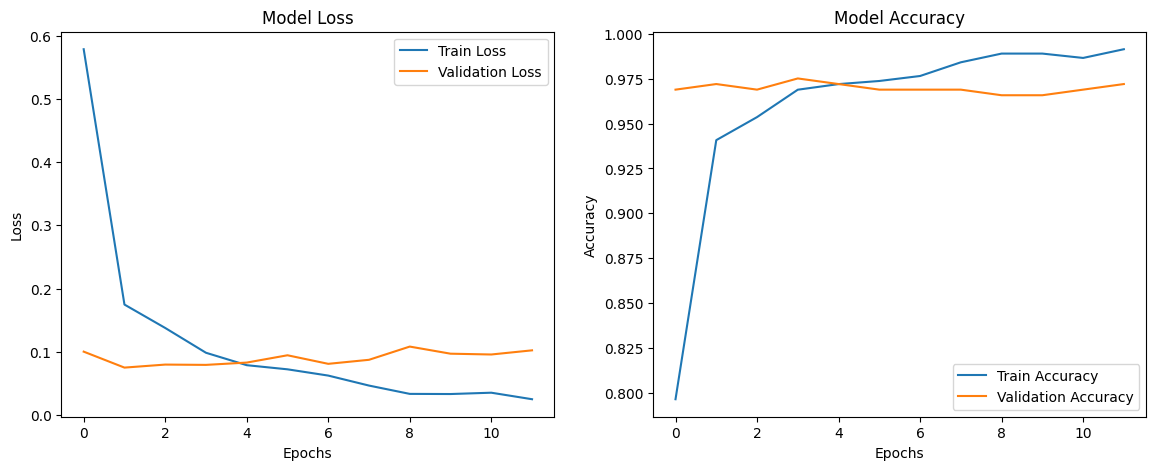

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Load EEG features
eeg_features = pd.read_csv("/kaggle/input/multimodal/train_features.csv")

# Load facial features
facial_features = pd.read_csv("/kaggle/input/multimodal/facial_feature_vectors (1).csv")

# Load labeled EEG data (contains theta and beta bands)
labeled_eeg_data = pd.read_csv("/kaggle/input/eeg-data/labeled_eeg_data.csv")

# Ensure both datasets have an 'emotion' column
if 'emotion' not in eeg_features.columns or 'emotion' not in facial_features.columns:
    raise ValueError("The 'emotion' column is missing from one of the datasets!")

# Extract labels from EEG dataset
labels = eeg_features['emotion'].values  # Get the emotion labels from the EEG dataset

# Convert categorical labels to numerical format
label_encoder = LabelEncoder()  # Initialize label encoder
labels_encoded = label_encoder.fit_transform(labels)  # Convert categorical labels (strings) to numeric values

# Convert labels to one-hot encoding (for classification tasks)
num_classes = len(np.unique(labels_encoded))  # Determine the number of unique emotion categories
labels_onehot = tf.keras.utils.to_categorical(labels_encoded, num_classes=num_classes)  # Convert to one-hot encoded format

# Drop 'emotion' column from both datasets, as we only need the feature vectors
eeg_features = eeg_features.drop(columns=['emotion'])
facial_features = facial_features.drop(columns=['emotion'])

# Align facial features with EEG data (Truncate or pad if needed)
facial_features = facial_features.iloc[:len(eeg_features)].reset_index(drop=True)  # Ensure both datasets have the same length

# Ensure data is properly aligned
assert len(eeg_features) == len(facial_features), "EEG and Facial features must have the same number of samples!"

# Extract cognitive load feature (Theta/Beta ratio from labeled EEG data)
def calculate_cognitive_load(eeg_data):
    # Check if theta and beta band columns exist in the dataset
    if not any(eeg_data.columns.str.contains('theta')) or not any(eeg_data.columns.str.contains('beta')):
        raise ValueError("Theta or Beta band columns missing in labeled EEG data!")
    
    theta_band = eeg_data.filter(regex='theta', axis=1).mean(axis=1)  # Compute mean theta power
    beta_band = eeg_data.filter(regex='beta', axis=1).mean(axis=1)  # Compute mean beta power
    
    return theta_band / beta_band  # Compute Cognitive Load Index (CLI) as theta/beta ratio

cognitive_load_index = calculate_cognitive_load(labeled_eeg_data)  # Compute CLI for each sample

# Define cognitive load categories based on CLI value
COGNITIVE_LOAD_THRESHOLD = 3.0  # Threshold value determined through analysis

def assess_cognitive_load(cli_value):
    # Categorize cognitive load into Low, Moderate, or High based on threshold
    if cli_value < 1.5:
        return "Low Load"
    elif 1.5 <= cli_value < COGNITIVE_LOAD_THRESHOLD:
        return "Moderate Load"
    else:
        return "High Load (⚠️ Alert)"  # Alert condition for high cognitive load

# Apply the function to get cognitive load labels for all samples
cognitive_load_labels = cognitive_load_index.apply(assess_cognitive_load)

# Alert the user when high cognitive load is detected
for i, cli in enumerate(cognitive_load_index):
    if cli >= COGNITIVE_LOAD_THRESHOLD:
        print(f"⚠️ Alert: High Cognitive Load detected for sample {i} (CLI: {cli:.2f})")

# Combine EEG and facial feature vectors into a single dataset
combined_features = np.hstack([eeg_features.values, facial_features.values])

# Normalize feature values to improve model performance
scaler = StandardScaler()  # Initialize standard scaler
combined_features_scaled = scaler.fit_transform(combined_features)  # Standardize features to zero mean, unit variance

# Split dataset into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(combined_features_scaled, labels_onehot, test_size=0.2, random_state=42)

# Build the neural network model for multimodal emotion classification
def build_multi_modal_model(input_dim):
    input_layer = Input(shape=(input_dim,))  # Define input layer with feature size
    x = Dense(256, activation='relu')(input_layer)  # Fully connected layer with 256 neurons
    x = Dropout(0.3)(x)  # Dropout for regularization (prevents overfitting)
    x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 neurons
    x = Dropout(0.3)(x)  # Dropout for regularization
    x = Dense(64, activation='relu')(x)  # Fully connected layer with 64 neurons
    output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for classification
    
    model = Model(inputs=input_layer, outputs=output_layer)  # Create the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile model
    
    return model

# Define input dimension based on the number of combined features
input_dim = combined_features_scaled.shape[1]
model = build_multi_modal_model(input_dim)  # Initialize the model

# Define callbacks for better training control
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Stop early if validation loss doesn't improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  # Reduce learning rate on plateau

# Train the model
history = model.fit(
    x_train, y_train,  # Training data
    epochs=50,  # Number of training epochs
    batch_size=32,  # Batch size for training
    validation_split=0.1,  # Use 10% of training data for validation
    callbacks=[early_stop, lr_scheduler]  # Apply early stopping and learning rate scheduler
)

# Evaluate model performance on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions on the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
true_labels = np.argmax(y_test, axis=1)  # Convert true labels to class labels

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_))

# Plot Training History (Loss & Accuracy over epochs)
plt.figure(figsize=(14, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()